In [2]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
import math
import sequtils as sue
from scipy.stats import linregress

In [31]:
frequencies = pd.read_csv('../../../data/frequencies/nicaragua_frequencies.csv', index_col=0)
frequencies.drop([gt for gt in frequencies.columns.values if 'SYLVATIC' in gt], inplace=True, axis=1)
genotypes = frequencies.columns.values

titer_path = '../../../data/katzelnick2015/processed/genotypes_normalized.csv'
print frequencies.head()

           DENV1_I  DENV1_II  DENV1_IV  DENV1_V  DENV2_ASIANAMERICAN  \
1970.0000   0.0072    0.0104    0.0164   0.0089               0.0069   
1970.0833   0.0074    0.0105    0.0169   0.0092               0.0070   
1970.1667   0.0076    0.0106    0.0174   0.0095               0.0070   
1970.2500   0.0078    0.0108    0.0180   0.0098               0.0071   
1970.3333   0.0080    0.0109    0.0185   0.0101               0.0071   

           DENV2_ASIANI  DENV2_COSMOPOLITAN  DENV3_I  DENV3_II  DENV3_III  \
1970.0000        0.0071              0.0082   0.0153    0.1196     0.0021   
1970.0833        0.0072              0.0084   0.0154    0.1201     0.0020   
1970.1667        0.0072              0.0085   0.0155    0.1205     0.0019   
1970.2500        0.0073              0.0087   0.0156    0.1209     0.0018   
1970.3333        0.0073              0.0089   0.0157    0.1212     0.0018   

           DENV3_IV  DENV4_I  DENV4_II  
1970.0000    0.0044   0.0087    0.0294  
1970.0833    0.0044   

In [32]:
# print titers.head()
def load_titers(titer_path):
    titers = pd.read_csv(titer_path, index_col=0)
    
    def fix_name(gt):
        gt = gt[:5]+'_'+gt[5:]
        gt = gt.replace('/', '').replace(' ', '').upper()
        return gt

    titers['virus_genotype'] = titers['virus_genotype'].map(fix_name)
    titers['serum_genotype'] = titers['serum_genotype'].map(fix_name)
    return titers

def average_normed_titers(titers):
    avg_titers = titers.groupby(['virus_genotype', 'serum_genotype'])['autologous_norm'].agg('mean')
    avg_titers = { tuple(sorted(k)):v for k,v in avg_titers.to_dict().items()}
    return avg_titers
    
titers = load_titers(titer_path)
avg_titers = average_normed_titers(titers)

In [33]:
def are_cocirculating(genotype1, genotype2, row):
    return row[genotype1] >= 0.1 and row[genotype2] >= 0.1

def avg_len_cocirculating(flag_series):    
    # first value is a True preceded by a False
    start = flag_series.index[flag_series & ~ flag_series.shift(1).fillna(False)]

    # last value is a True followed by a False
    end = flag_series.index[flag_series & ~ flag_series.shift(-1).fillna(False)]
    time_periods = zip(start, end)
    len_cocirculating = [end - start for start,end in time_periods]

    try:
        avg_len_cocirculating = float(sum(len_cocirculating)) / float(len(len_cocirculating))
    except ZeroDivisionError:
        avg_len_cocirculating = 0.

    return avg_len_cocirculating


def get_cocirculation_stability(df, genotypes=genotypes):
    genotype_pairs = combinations(genotypes, 2)
    
    len_cocirc = {}
    
    for (g1,g2) in genotype_pairs:
        cocirculating_boolean_series = df.apply(lambda x: are_cocirculating(g1,g2,x), axis=1)
        key = tuple(sorted([g1,g2]))
        len_cocirc[key] = avg_len_cocirculating(cocirculating_boolean_series)
    
    return len_cocirc

def both_present((g1, g2), df):
    max_freqs = df.max()
    return max_freqs[g1] >= 0.1 and max_freqs[g2] >=0.1

In [50]:
def compare_cocirculation_stability_titers(df, avg_titers=avg_titers, genotypes=genotypes):
    len_cocirc = get_cocirculation_stability(df)
    avg_norm_titers = average_normed_titers(titers)
    
    genotype_pairs = [g for g in sorted([g for g in combinations(genotypes, 2)]) if g[0] != g[1]]
    
    xvals = []
    yvals = []
    missing = 0
    for g in genotype_pairs:
        try:
            x = avg_norm_titers[g]
            y = len_cocirc[g]
            if not np.isnan(x):
                if y != 0. or both_present(g, df):
                    xvals.append(x)
                    yvals.append(y)
        except KeyError as e:
            missing += 1
            continue
    
    print len(genotype_pairs)
    print missing
    fit = linregress(xvals, yvals)
    return {'titer_dist': xvals, 'cocirc_length': yvals, 'rvalue': fit.rvalue, 'slope': fit.slope}

def shuffle_labels(df):
    shuffled = df.copy()
    np.random.shuffle(shuffled.columns.values)
    return shuffled

def generate_null(df, n=100):
    null_distribution_slope = []
    null_distribution_r = []
    for i in range(n):
        shuffled_df = shuffle_labels(df)
        null_distribution_slope.append(compare_cocirculation_stability_titers(shuffled_df)['slope'])
        null_distribution_r.append(compare_cocirculation_stability_titers(shuffled_df)['rvalue'])
    return {'r': null_distribution_r, 'slope': null_distribution_slope}

In [51]:
test_stats = compare_cocirculation_stability_titers(frequencies)

78
46


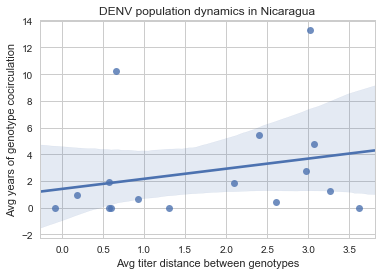

In [47]:
sns.set_style('whitegrid')
sns.regplot(pd.Series(test_stats['titer_dist']),pd.Series(test_stats['cocirc_length']))
plt.xlabel('Avg titer distance between genotypes')
plt.ylabel('Avg years of genotype cocirculation')
plt.title('DENV population dynamics in Nicaragua')

In [ ]:
null_distrib = generate_null(frequencies)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
null_r = sns.kdeplot(pd.Series(null_distrib['r']), ax=ax[0])
null_r.plot([southeast_asia_results['rvalue'] for i in np.linspace(0.,2.)], [i for i in np.linspace(0.,2.)])
null_r.set_xlabel('r')
null_r.set_ylim(0, 2)

null_slope = sns.kdeplot(pd.Series(null_distrib['slope']), ax=ax[1])
null_slope.plot([southeast_asia_results['slope'] for i in np.linspace(0.,1.)], [i for i in np.linspace(0.,1.)])
null_slope.set_xlabel('slope')
null_slope.set_ylim(0,2)

plt.suptitle('Association between\ncocirculation stability and antigenic distance', va='bottom')
plt.tight_layout()